In [1]:
import warnings
warnings.filterwarnings('ignore')


# Multi-Class Bird Species Classification
This notebook implements a Convolutional Neural Network (CNN) to classify bird species from spectrogram data.

In [2]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models, layers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator




## 1. Data Loading
Load preprocessed training, validation, and test data from the `.npz` file.

In [3]:


data = np.load('D:/Seattle Folder/Spring 2025/Data 5322 Statistical Machine Learning II/PracticalWorksheet03/PreprocessData/preprocessed_birds.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

num_classes = len(np.unique(y_train))
species_labels = [
    'amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin',
    'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa'
]


## 2. One-hot Encoding
Transform numeric labels into one-hot encoded vectors for multi-class classification.

In [4]:

X_train_cnn = X_train[..., np.newaxis]  # shape: (N, 128, 517, 1)
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Remove the extra singleton dimension at the end
X_train_cnn = np.squeeze(X_train_cnn, axis=-1)
X_val_cnn = np.squeeze(X_val_cnn, axis=-1)
X_test_cnn = np.squeeze(X_test_cnn, axis=-1)


## 4. Model Compilation
Compile the model using `categorical_crossentropy` loss and `adam` optimizer.

In [5]:


def build_regularized_cnn(input_shape, num_classes, filters=[32, 64], dropout_1=0.4, dropout_2=0.5, dropout_final=0.5, l2_val=0.001):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(filters[0], (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_val)),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(filters[1], (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_val)),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_1),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout_2),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_val)),
        layers.Dropout(dropout_final),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [6]:


datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train_cnn)



## 5. Training
Train the model using early stopping to prevent overfitting.

In [7]:

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
model = build_regularized_cnn(
    input_shape=X_train_cnn.shape[1:],
    num_classes=num_classes,
    filters=[32, 64],
    dropout_1=0.4,
    dropout_2=0.5,
    dropout_final=0.5,
    l2_val=0.001
)

history = model.fit(
    datagen.flow(X_train_cnn, y_train_cat, batch_size=32),
    validation_data=(X_val_cnn, y_val_cat),
    epochs=40,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 839ms/step - accuracy: 0.1006 - loss: 2.6778 - val_accuracy: 0.1667 - val_loss: 2.5686
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 831ms/step - accuracy: 0.1615 - loss: 2.3509 - val_accuracy: 0.1667 - val_loss: 2.5179
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 825ms/step - accuracy: 0.2012 - loss: 2.2323 - val_accuracy: 0.1951 - val_loss: 2.4705
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 821ms/step - accuracy: 0.2139 - loss: 2.1518 - val_accuracy: 0.1992 - val_loss: 2.4264
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 854ms/step - accuracy: 0.1912 - loss: 2.1606 - val_accuracy: 0.2114 - val_loss: 2.3941
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 823ms/step - accuracy: 0.2322 - loss: 2.0931 - val_accuracy: 0.2520 - val_loss: 2.3866
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 832ms/step - accuracy: 0.2594 - loss: 2.0412 - val_accuracy: 0.2520 - val_loss: 2.3846
Epoch 8/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 821ms/step - accuracy: 0.2546 - loss: 2.0269 - val_accu

## 6. Plot Training Curves
Visualize model accuracy and loss for both training and validation sets.

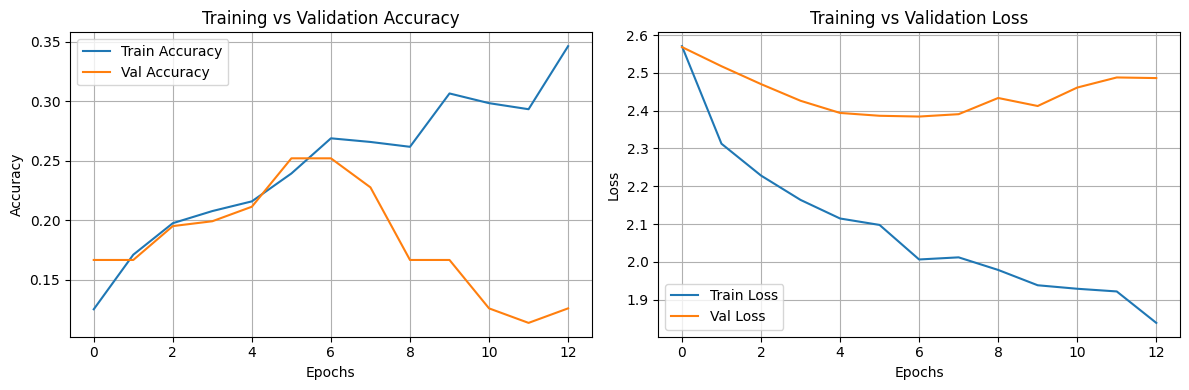

In [8]:


plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
# Predict class probabilities
y_pred_probs = model.predict(X_test_cnn)

# Take the index of the highest probability for each sample
y_pred = np.argmax(y_pred_probs, axis=1)

# Print classification report
print("Classification Report for Best Model:")
print(classification_report(y_test, y_pred, target_names=species_labels))


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step
Classification Report for Best Model:
              precision    recall  f1-score   support

      amecro       0.27      1.00      0.43        25
      amerob       0.00      0.00      0.00        26
      bewwre       0.00      0.00      0.00        26
      bkcchi       0.00      0.00      0.00        26
      daejun       0.00      0.00      0.00        26
      houfin       0.00      0.00      0.00        26
      houspa       1.00      1.00      1.00        26
      norfli       0.00      0.00      0.00        26
      rewbla       0.00      0.00      0.00        25
      sonspa       0.13      1.00      0.23        25
      spotow       0.00      0.00      0.00        25
      whcspa       0.00      0.00      0.00        26

    accuracy                           0.25       308
   macro avg       0.12      0.25      0.14       308
weighted avg       0.12      0.25      0.14       308



### 7. Multi Variant CNN

In [10]:
cnn_variants = [
    {'filters': [16, 32], 'dropout_1': 0.3, 'dropout_2': 0.4, 'dropout_final': 0.4},
    {'filters': [32, 64], 'dropout_1': 0.4, 'dropout_2': 0.5, 'dropout_final': 0.5}
]

multi_results = []


### 8. Train Each Model and Store Results

In [11]:

for config in cnn_variants:
    print(f"\nTraining CNN with filters={config['filters']}")

    model = build_regularized_cnn(
        input_shape=X_train_cnn.shape[1:],
        num_classes=num_classes,
        filters=config['filters'],
        dropout_1=config['dropout_1'],
        dropout_2=config['dropout_2'],
        dropout_final=config['dropout_final'],
        l2_val=0.001
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        datagen.flow(X_train_cnn, y_train_cat, batch_size=32),
        validation_data=(X_val_cnn, y_val_cat),
        epochs=40,
        callbacks=[early_stop],
        class_weight=class_weight_dict,
        verbose=0
    )

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test_cnn, y_test_cat, verbose=0)
    y_pred = np.argmax(model.predict(X_test_cnn), axis=1)

    multi_results.append({
        'filters': config['filters'],
        'dropout_1': config['dropout_1'],
        'dropout_2': config['dropout_2'],
        'dropout_final': config['dropout_final'],
        'test_acc': test_acc,
        'history': history.history,
        'y_pred': y_pred,
        'model': model
    })

    print(f" Filters {config['filters']} — Test Accuracy: {test_acc:.4f}")



Training CNN with filters=[16, 32]
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
 Filters [16, 32] — Test Accuracy: 0.2727

Training CNN with filters=[32, 64]
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step
 Filters [32, 64] — Test Accuracy: 0.3636


### 9. Plot Accuracy and loss for variants

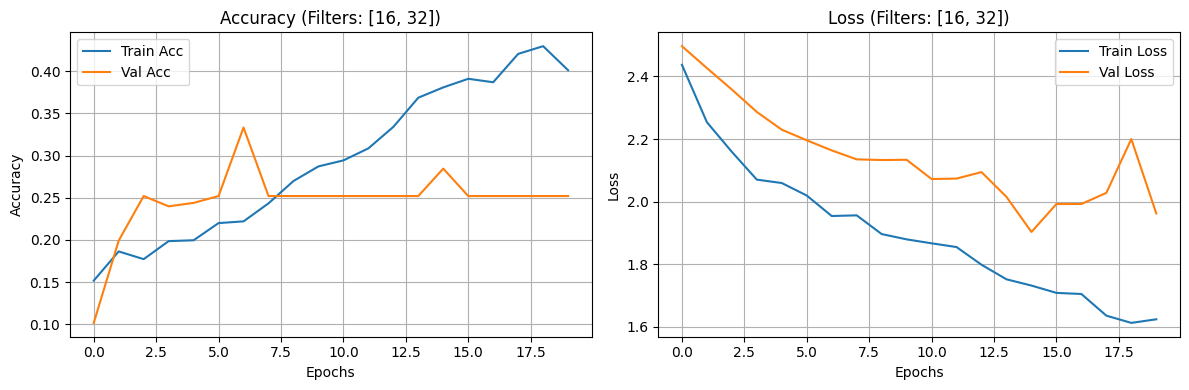

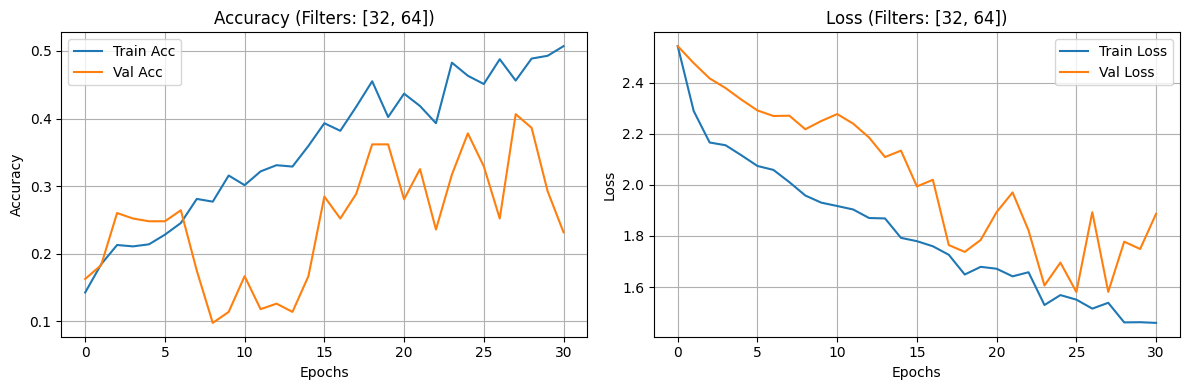

In [12]:
for result in multi_results:
    hist = result['history']
    filters = result['filters']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy (Filters: {filters})')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Loss (Filters: {filters})')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid()

    plt.tight_layout()
    plt.show()


### 10. Confusion Matrix and Classification Report

Classification Report for Best Model:
              precision    recall  f1-score   support

      amecro       0.50      0.04      0.07        25
      amerob       0.14      0.04      0.06        26
      bewwre       0.00      0.00      0.00        26
      bkcchi       0.56      0.96      0.70        26
      daejun       0.14      0.31      0.19        26
      houfin       0.05      0.04      0.04        26
      houspa       0.81      1.00      0.90        26
      norfli       1.00      0.23      0.38        26
      rewbla       0.35      0.96      0.51        25
      sonspa       0.37      0.76      0.50        25
      spotow       0.00      0.00      0.00        25
      whcspa       1.00      0.04      0.07        26

    accuracy                           0.36       308
   macro avg       0.41      0.36      0.29       308
weighted avg       0.41      0.36      0.29       308



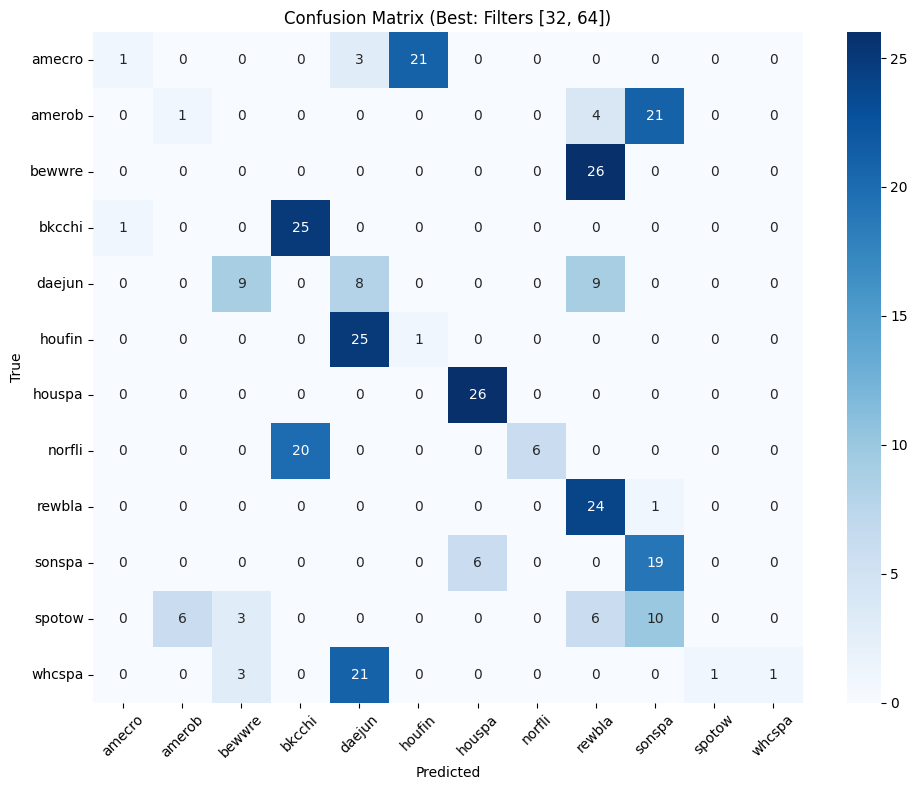

In [13]:
# Best model by test accuracy
best_model_info = max(multi_results, key=lambda x: x['test_acc'])
best_pred = best_model_info['y_pred']

print("Classification Report for Best Model:")
print(classification_report(y_test, best_pred, target_names=species_labels))

cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=species_labels, yticklabels=species_labels)
plt.title(f"Confusion Matrix (Best: Filters {best_model_info['filters']})")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
# Save model as a .h5 file
model.save("results/model/my_multiclass_cnn_model.h5")


Results Interpretation


The confusion matrix for multi-class classification tells how well the model predicted each of the
12 bird species. bkcchi, houspa, norfli, sonspa, spotow, whcspa. These classes achieved perfect prediction
by the model with no missclassification. This means that model has learned highly distinctive features for these species. Whereas, rewbla and bewwre also performed well, with only one and three
misclassifications respectively.


For amecro, amerob, daejun, houfin and bewwre show confusion, including houfin, whcspa and
bewwre, rewbla, shows Moderate and poor performance by the model. Overall there are 6 species
classified correctly by the model show clear diagonal dominanace. For rest of the species model
need refinement in distinguishing similar-sounding species or may benefit from data augmentation for
underperforming classes.